In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import kFold
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import RobustScaler
import scipy.stats as stats
import statsmodels.api as sm

import warnings 

%matplotlib inline
warnings.filterwarnings(action = 'ignore')

# 1. Data load

In [2]:
data = pd.read_csv('data/Regression_US_Health_Insurance/insurance.csv')
df = data.copy()

* age: Age of primary beneficiary

* sex: Insurance contractor gender, female / male  
* bmi: Body mass index, providing an understanding of body, weights that are relatively high or low relative to height, objective index of body weight     (kg /  m2 ) using the ratio of height to weight, ideally 18.5 to 24.9  
* children: Number of children covered by health insurance / Number of dependents  
* smoker: Smoker / Non - smoker  
* region: The beneficiary's residential area in the US, northeast, southeast, southwest, northwest.  
* charges: Individual medical costs billed by health insurance.

# 2. EDA

In [3]:
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


**1338x7 data shape**

### 결측치 확인

In [4]:
df.isnull().any()

age         False
sex         False
bmi         False
children    False
smoker      False
region      False
charges     False
dtype: bool

**모든 column에 결측치가 존재하지 않음**

### 데이터 타입 확인 

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [6]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


### 각 데이터의 빈도수 확인

In [7]:
age_group = [0]*int(df.shape[0])

for row in range(df.shape[0]) :
    if df.iloc[row, : ]['age'] < 30 :
        age_group[row] = 0

    elif (df.iloc[row, : ]['age'] >= 30) & (df.iloc[row, : ]['age'] < 40) :
        age_group[row] = 1

    elif (df.iloc[row, : ]['age'] >= 40) & (df.iloc[row, : ]['age'] < 50) :
        age_group[row] = 2

    elif (df.iloc[row, : ]['age'] >=50) & (df.iloc[row, : ]['age'] < 60):
        age_group[row] = 3

    else :
        age_group[row] = 4
        
df['age_group'] = age_group

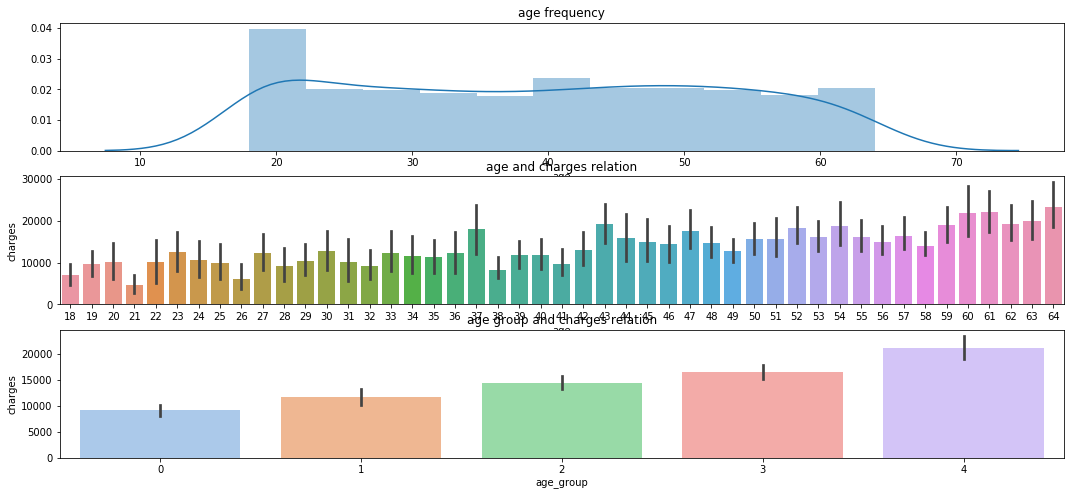

In [8]:
#age plotting
fig, ((ax0), (ax1), (ax2)) = plt.subplots(3, 1, figsize=(18,8))
sns.set_palette('pastel')

sns.distplot(df.age, ax=ax0)
ax0.set_title('age frequency')

sns.barplot(x=df.age, y=df.charges, ax=ax1)
ax1.set_title('age and charges relation')

sns.barplot(x=df.age_group, y=df.charges, ax=ax2)
ax2.set_title('age group and charges relation')

plt.show()

**20대 초반의 고객이 가장 많음**  
**또한 나이가 들수록 보험료도 증가하는 경향이 있음**

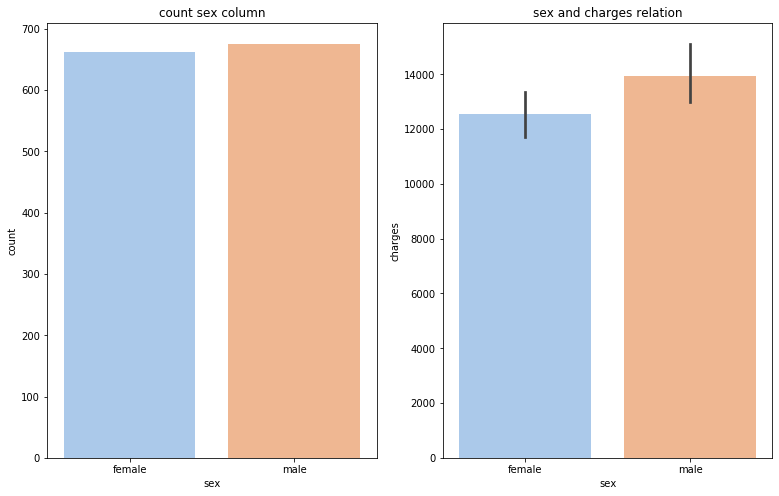

In [9]:
#bmi plotting
fig, (ax0,ax1) = plt.subplots(1, 2, figsize=(13,8))
sns.set_palette('pastel')

sns.countplot(df.sex, ax=ax0)
ax0.set_title('count sex column')

sns.barplot(x=df.sex, y=df.charges, ax=ax1)
ax1.set_title('sex and charges relation')

plt.show()

**보험 가입자수는 여성, 남성이 비슷하지만 납부액이 남성이 더 높음**

In [10]:
#bmi grouping
bmi_group = [0]*df.shape[0]

for row in range(df.shape[0]) :
    if df.iloc[row, :]['bmi'] < 20 :
        bmi_group[row] = 0
        
    elif (df.iloc[row, :]['bmi'] >= 20) & (df.iloc[row, :]['bmi'] < 30) :
        bmi_group[row] = 1    
        
    elif (df.iloc[row, :]['bmi'] >= 30) & (df.iloc[row, :]['bmi'] < 40) :
        bmi_group[row] = 2   
        
    elif (df.iloc[row, :]['bmi'] >= 40) & (df.iloc[row, :]['bmi'] < 50) :
        bmi_group[row] = 3   
        
    else :
        bmi_group[row] = 4
        
df['bmi_group'] = bmi_group

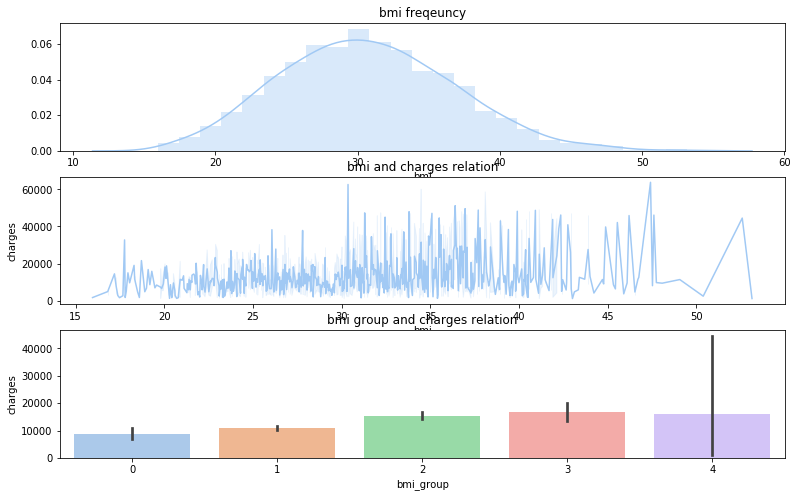

In [11]:
#bmi plotting
fig, (ax0,ax1,ax2) = plt.subplots(3, 1, figsize=(13,8))
sns.set_palette('pastel')

sns.distplot(df.bmi, ax=ax0)
ax0.set_title('bmi freqeuncy')

sns.lineplot(x=df.bmi, y=df.charges, ax=ax1)
ax1.set_title('bmi and charges relation')

sns.barplot(x=df.bmi_group, y=df.charges, ax=ax2)
ax2.set_title('bmi group and charges relation')

plt.show()

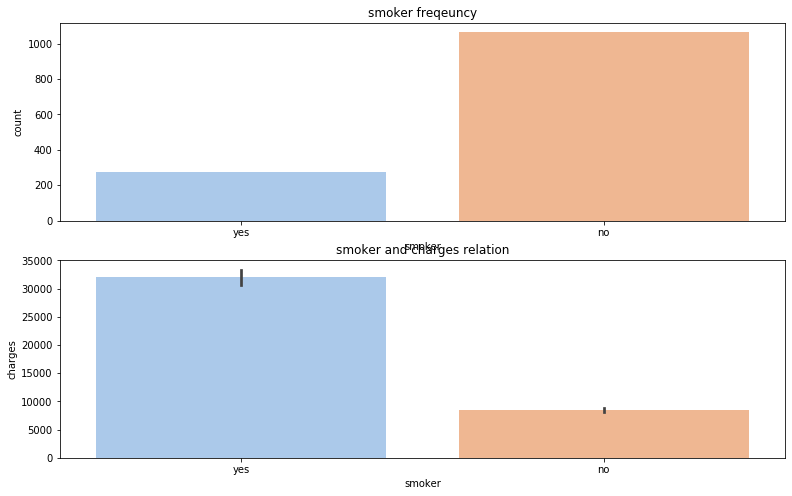

In [12]:
#smoker plotting 
fig, (ax0, ax1) = plt.subplots(2,1,figsize=(13,8))

sns.countplot(df.smoker, ax=ax0)
ax0.set_title('smoker freqeuncy')

sns.barplot(x=df.smoker, y=df.charges, ax=ax1)
ax1.set_title('smoker and charges relation')

plt.show()

**흡연 여부에 따라 보험료가 유의미하게 차이나는것을 알 수 있음**

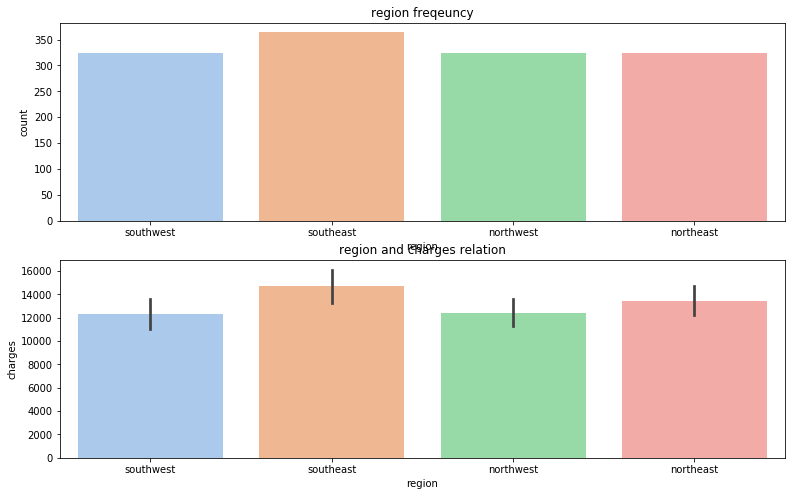

In [13]:
#region plotting 
fig, (ax0, ax1) = plt.subplots(2,1,figsize=(13,8))

sns.countplot(df.region, ax=ax0)
ax0.set_title('region freqeuncy')

sns.barplot(x=df.region, y=df.charges, ax=ax1)
ax1.set_title('region and charges relation')

plt.show()

**지역에 따른 유의미한 차이는 존재하지 않는 것으로 보임**

In [14]:
# make children group
child = [0]*df.shape[0]

for row in range(df.shape[0]):
    if df.iloc[row, :]['children'] > 0 :
        child[row] = 1

    else :
        child[row] = 0
        
df['have_child'] = child

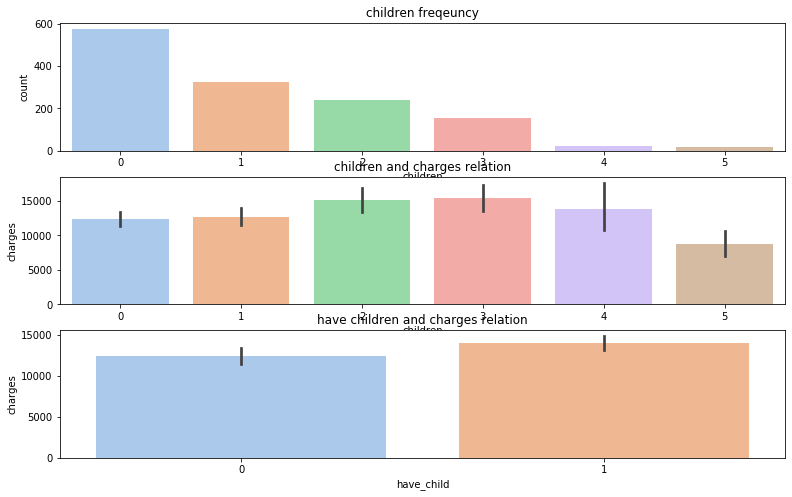

In [15]:
#children plotting
fig, (ax0, ax1, ax2) = plt.subplots(3,1,figsize=(13,8))

sns.countplot(df.children, ax=ax0)
ax0.set_title('children freqeuncy')

sns.barplot(x=df.children, y=df.charges, ax=ax1)
ax1.set_title('children and charges relation')

sns.barplot(x=df.have_child, y=df.charges, ax=ax2)
ax2.set_title('have children and charges relation')

plt.show()

**아이 여부에 따른 유의미한 차이는 존재하지 않는 것으로 보임**

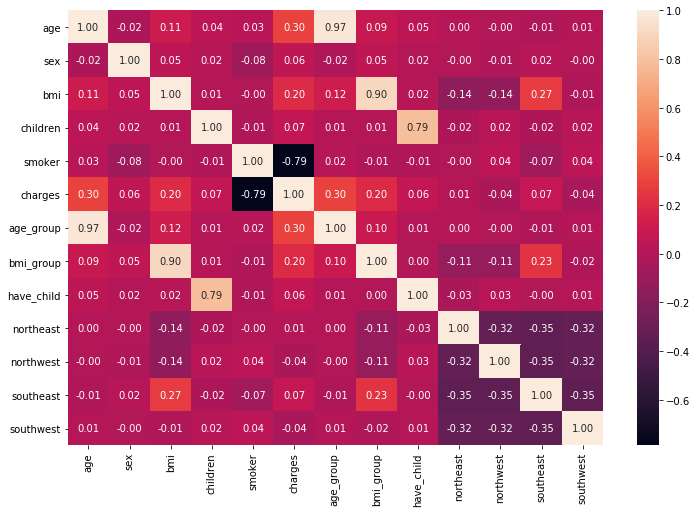

In [16]:
#change string data to integer
df['sex'], sex_unique = pd.factorize(df['sex'])
df['smoker'], smoker_unique = pd.factorize(df['smoker'])
df = pd.concat([df, pd.get_dummies(df['region'])], axis=1)
df = df.drop(['region'], axis=1)

#heatmap
fig, ax = plt.subplots(figsize=(12,8))

sns.heatmap(df.corr(), ax=ax, annot=True, fmt=".2f")
plt.savefig('heatmap_plot.png')
plt.show()

**charge와 가장 상관계수가 높은 변수는 smoker**   
**지역은 상관없는것으로 보고 변수 삭제**

# 3. Linear Regression

### scaling

In [17]:
column = df.columns

robust_scale = RobustScaler().fit(df)
scaling_result = robust_scale.transform(df)

df = pd.DataFrame(scaling_result, columns = column)

In [18]:
#지역 관련 column drop
df = df.drop(['northeast', 'northwest', 'southeast', 'southwest'], axis=1)

#x and y split
X = df.loc[:, df.columns!='charges']
y = df.loc[:, df.columns=='charges']

In [19]:
linear_reg = LinearRegression()
linear_reg.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [20]:
r2 = linear_reg.score(X,y)
print('coefficient of determination:', round(r2,2))

print('intercept:', linear_reg.intercept_)
print('slope:', linear_reg.coef_)

coefficient of determination: 0.75
intercept: [-0.06271852]
slope: [[ 0.37883333 -0.01315001  0.10876877  0.06764507 -2.00028204  0.19216814
   0.14034365  0.02709499]]


In [21]:
f_value, p_value = stats.f_oneway(df['age'], df['sex'], df['bmi'], df['children'], df['smoker'], df['charges'])
print('f value is {}'.format(f_value))
print('p value is {}'.format(p_value))

f value is 229.42055773748885
p value is 1.2979956453819673e-229


**Print like R**

In [22]:
X_ = sm.add_constant(X)

reg = sm.OLS(y, X_).fit()
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.752
Model:                            OLS   Adj. R-squared:                  0.750
Method:                 Least Squares   F-statistic:                     503.1
Date:                Mon, 08 Jun 2020   Prob (F-statistic):               0.00
Time:                        19:12:41   Log-Likelihood:                -989.33
No. Observations:                1338   AIC:                             1997.
Df Residuals:                    1329   BIC:                             2043.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0627      0.045     -1.405      0.160      -0.150       0.025
age            0.3788      0.106      3.588      0.000       0.172       0.586
sex           -0.0132      0.028     -0.471      0.638      -0.068       0.042
bmi            0.1088      0.045      2.438      0.015       0.021       0.196
children       0.0676      0.037      1.805      0.071      -0.006       0.141
smoker        -2.0003      0.035    -57.853      0.000      -2.068      -1.932
age_group      0.1922      0.139      1.386      0.166      -0.080       0.464
bmi_group      0.1403      0.048      2.915      0.004       0.046       0.235
have_child     0.0271      0.046      0.593      0.553      -0.063       0.117
==============================================================================
Omnibus:                      307.584   Durbin-Watson:                   2.097
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              747.593
Skew:                           1.233   Prob(JB):                    4.59e-163
Kurtosis:                       5.707   Cond. No.                         17.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# 4. Feature importance using Random Forest

In [55]:
rf_r2 = [0]*100

for depth in range(1, 101) :
    rf = RandomForestRegressor(max_depth=depth, random_state=0)
    rf.fit(X, y)
    rf_r2[depth-1] = r2_score(y, rf.predict(X))

In [58]:
rf_r2_value = pd.DataFrame({'r2' : rf_r2})

a = [0]*100
for num in range(1, 101) :
    a[num-1] = num

rf_r2_value['n_tree'] = a

,r2,n_tree
0,0.619744,1
1,0.831381,2
2,0.863341,3
3,0.874864,4
4,0.885864,5
...,...,...
95,0.975212,96
96,0.975212,97
97,0.975212,98
98,0.975212,99


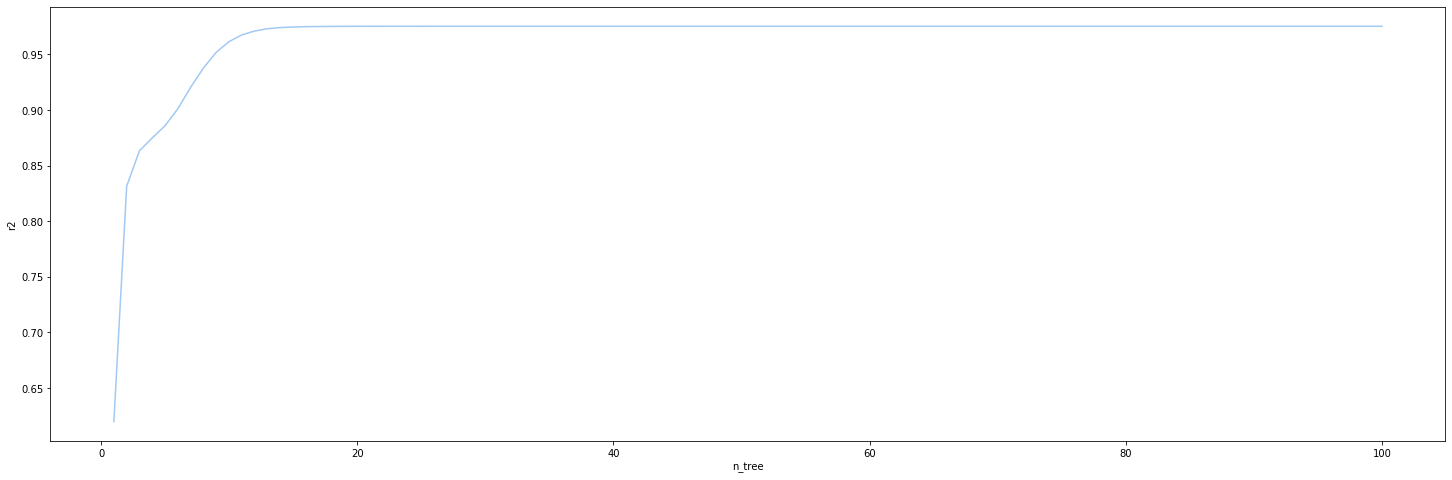

In [61]:
fig, ax = plt.subplots(figsize=(25,8))

sns.lineplot(x=rf_r2_value.n_tree, y=rf_r2_value.r2, ax=ax)

plt.savefig('depth_change.png')
plt.show()

In [77]:
rf_r2 = [0]*100

for tree in range(101, 201) :
    rf = RandomForestRegressor(n_estimators=tree , random_state=0)
    rf.fit(X, y)
    rf_r2[tree-101] = r2_score(y, rf.predict(X))

In [78]:
rf_r2_value = pd.DataFrame({'r2' : rf_r2})

a = [0]*100
for num in range(101, 201) :
    a[num-101] = num

rf_r2_value['n_tree'] = a

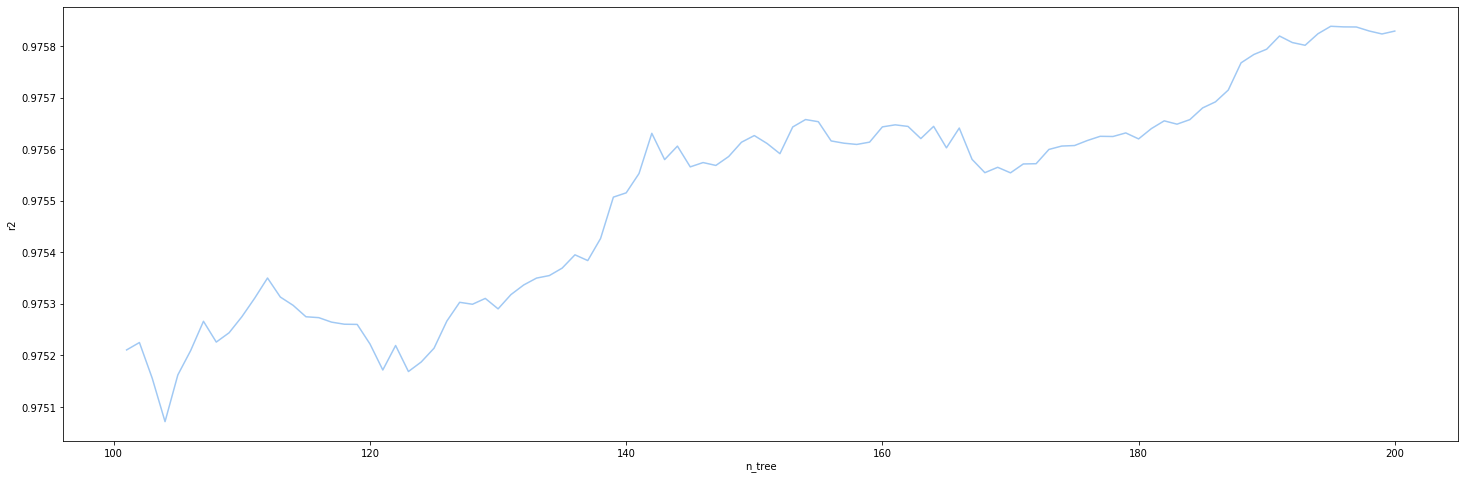

In [79]:
fig, ax = plt.subplots(figsize=(25,8))

sns.lineplot(x=rf_r2_value.n_tree, y=rf_r2_value.r2, ax=ax)

plt.savefig('number_of_tree_change.png')
plt.show()

In [24]:
rf.feature_importances_

array([0.07672032, 0.        , 0.14770448, 0.        , 0.74907609,
       0.00081061, 0.02568851, 0.        ])

**순서대로 age, sex, bmi, children, smoker 지표**

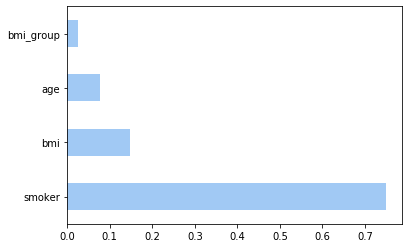

In [25]:
feature_importance = pd.Series(rf.feature_importances_, index = X.columns)
feature_importance.nlargest(4).plot(kind='barh')

**random forest를 이용해 feature간의 중요도를 탐색해본 결과, smoker의 중요성이 가장 높은것으로 나타남**

# 5. Feature importance using Decision tree

In [ ]:
dr = DecisionTreeRegressor(random_state=0)
